# 1.) Import an asset price from Yahoo Finance

In [3]:
pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 6.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [33]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("AAPL", start="1990-01-01", end="2022-02-21")
stock_data['Change'] = stock_data['Close'].pct_change()
stock_data['Change'].dropna() 
stock_data['Direction'] = np.where(stock_data['Change'] > 0, 1, 0)

# Preprocess data
scaled_data = np.array(stock_data["Change"])
                       
#scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)
# Split data into training and test sets

training_data_len = int(len(scaled_data) * 0.8)
#train_data = scaled_data[0:training_data_len, :]

train_data = scaled_data[0:training_data_len]

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Change,Direction
Date,,,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.264482,183198400,NaN,0
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.266257,207995200,0.006711,1
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.267145,221513600,0.003336,1
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.268033,123312000,0.003322,1
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.269808,101572800,0.006622,1
...,...,...,...,...,...,...,...,...
2022-02-14,167.369995,169.580002,166.559998,168.880005,167.863129,86185500,0.001423,1
2022-02-15,170.970001,172.949997,170.250000,172.789993,171.749588,62527400,0.023152,1
2022-02-16,171.850006,173.339996,170.050003,172.550003,171.511047,61177400,-0.001389,0


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [25]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i])
    y_train.append(train_data[i])
    
    #x_train.append(train_data[i-input_size:i, 0])
    #y_train.append(train_data[i, 0])# if y_train[i] > 0 : 1
                                      # elif y_train[i] < 0 : 0


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
#Examples
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25)) 
model.add(Dense(5)) # Dropout Percentage
# Classification : Pick your activation function
model.add(Dense(1))

model.compile(optimizer='adam', metrics = 'accuracy', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
6473/6473 [==============================] - 44s 6ms/step - loss: nan - accuracy: 0.0272
Epoch 2/3
6473/6473 [==============================] - 75s 12ms/step - loss: nan - accuracy: 0.0272
Epoch 3/3
6473/6473 [==============================] - 100s 15ms/step - loss: nan - accuracy: 0.0272


In [36]:
len(x_train)
len(y_train)

6473

# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [37]:

#test_data = scaled_data[training_data_len - input_size:, :]
test_data = scaled_data[training_data_len - input_size:]

x_test = []
#y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
y_test = np.array(stock_data['Change'].dropna())[training_data_len-1:]
for i in range(input_size, len(test_data)):
     x_test.append(test_data[i-input_size:i])
    #x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)

51/51 [==============================] - 0s 3ms/step


In [38]:
y_test

array([ 0.00111803, -0.02138996, -0.00412571, ..., -0.00138891,
       -0.02126919, -0.00935577])

In [39]:
# In-sample accuracy
train_loss, train_acc = model.evaluate(x_train, y_train)
print('In-sample accuracy:', train_acc)

# Out-of-sample accuracy
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Out-of-sample accuracy:', test_acc)


203/203 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0272
In-sample accuracy: 0.027189865708351135
51/51 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0019
Out-of-sample accuracy: 0.0018518518190830946


In [40]:
y_train_actual = y_train[1:]
y_train_pred = y_train[:-1]

y_test_actual = y_test[1:]
y_test_pred = y_test[:-1]

In [41]:
# In-sample random walk accuracy
train_acc_random = np.mean(y_train_actual == y_train_pred)
print('In-sample random walk accuracy:', train_acc_random)

# Out-of-sample random walk accuracy
test_acc_random = np.mean(y_test_actual == y_test_pred)
print('Out-of-sample random walk accuracy:', test_acc_random)

In-sample random walk accuracy: 0.0015451174289245982
Out-of-sample random walk accuracy: 0.0


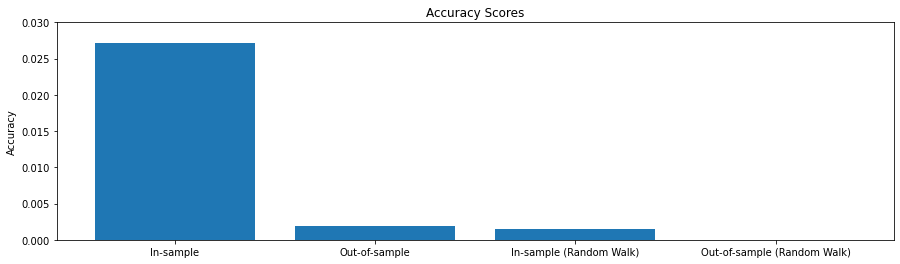

In [42]:
import matplotlib.pyplot as plt
plt.figure().set_figwidth(15)
labels = ['In-sample', 'Out-of-sample', 'In-sample (Random Walk)', 'Out-of-sample (Random Walk)']
accuracy_scores = [train_acc, test_acc, train_acc_random, test_acc_random]

plt.bar(labels, accuracy_scores)
plt.ylim((0,0.03))
plt.title('Accuracy Scores')
plt.ylabel('Accuracy')
plt.show()


DONT DO # 4.) Plot in and out of sample accuracy

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

Both the in-sample and out-of-sample accuracies are higher than the corresponding accuracies of the random walk, which means that this model is able to capture some kind of meaningful patterns between Apple stock price over time. 

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [45]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
###Edit here to create your optimizer
def create_model(input_size):
  for i in range(input_size, len(train_data)):
    x_train = []
    y_train = []
    x_train.append(train_data[i-input_size:i])
    y_train.append(train_data[i])
    #x_train.append(train_data[i-input_size:i,0])
    #y_train.append(train_data[i,0])
    
                   
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

  #Globally change your inputs
    model = Sequential()
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25)) 
    model.add(Dense(5))
    model.add(Dense(1))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
####EXAMPLE###
param_grid = {'batch_size': [10, 20, 100],
              'epochs': [10, 100],
              'input_size':[5,10,20]}

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-45-3f960941b09e>:31: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: nan using {'batch_size': 10, 'epochs': 10, 'input_size': 5}
